<a href="https://colab.research.google.com/github/fomin-max/bank_marketing/blob/master/bank_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Прогнозирование срочных депозитов</center>
<center> Автор: Фомин Максим

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn import tree
from io import BytesIO as StringIO
import pydotplus
from IPython.display import Image

matplotlib.style.use('ggplot')
%matplotlib inline

## <center>Информация о наборе данных: 

Данные связаны с маркетинговыми кампаниями банковского учреждения. Маркетинговые кампании были основаны на телефонных звонках. Часто требовалось более одного контакта с одним и тем же клиентом, чтобы клиент сделал срочный депозит. Срочный депозит - это депозит, который банк или финансовый институт предлагает с фиксированной ставкой (часто лучше, чем просто открытие депозитного счета), в котором ваши деньги будут возвращены в определенный срок. </center>

In [0]:
df = pd.read_csv('bank_marketing.csv')
df.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Каждая строка представляет собой одного клиента - это **объект** исследования.  
Столбцы - **признаки** объекта.


Описание признаков объекта:


Данные клиента банка:

**age** - Возраст, количественный признак  
**job** - Тип работы, номинальный признак ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
**marital** - Семейное положение, номинальный признак ('divorced','married','single','unknown')  
**education** - Образование, номинальный признак (primary, secondary, tertiary and unknown)  
**default** - Имеет ли кредит, номинальный признак ('no','yes','unknown')  
**housing** - Имеет ли кредит на жилье, номинальный признак ('no','yes','unknown')  
**loan** - Имеет ли личные займы, номинальный признак ('no','yes','unknown')

Связано с последним контактом текущей кампании:

**contact** - Тип связи, номинальный признак ('cellular','telephone')  
**month** - Месяц последнего контакта с клиентом, номинальный признак ('jan', 'feb', 'mar', ..., 'nov', 'dec')  
**day_of_week** - День недели последнего контакта с клиентом, номинальный признак ('mon','tue','wed','thu','fri')

Другие признаки:

**campaign** - Количество контактов, выполненных во время этой кампании и для этого клиента, количественный признак  
**pdays** -  количество дней, прошедших после последнего контакта с клиентом из предыдущей кампании, количественный признак (999 означает, что с клиентом ранее не связывались)  
**previous** - Количество контактов, выполненных до этой кампании и для этого клиента, количественный признак  
**poutcome** - Результат предыдущей маркетинговой кампании, номинальный признак ('failure','nonexistent','success')

Признаки социально-экономического характера:

**emp.var.rate** - Уровень вариации занятости - квартальный показатель, количественный признак    
**cons.price.idx** - Индекс потребительских цен - месячный показатель, количественный признак  
**cons.conf.idx** - Индекс доверия потребителей - месячный показатель, количественный признак   
**euribor3m** - Ставка межбанковского кредитования - дневной показатель, количественный признак   
**nr.employed** - Количество работников - квартальный показатель, количественный признак   
  
Целевая переменная: **y** - Подписал ли клиент срочный депозит, бинарный признак ('yes','no') 

### Посмотрим, имеются ли пропущенные значения. Посчитаем, сколько строчек их содержит.

In [0]:
print('Rows in the data frame: ', len(df))
print('Rows without NAN: ', len(df.dropna(how='any')))

Rows in the data frame:  41188
Rows without NAN:  41188


### Строк с пропущенными значениями нет. Далее необходимо удалить 1 столбец (нумерацию).


In [0]:
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
#Просмотр типов данных
df.info()

# Все данные заполнены, пропусков нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


### Проверим, имеются ли столбцы с постоянным значением

In [0]:
df[[c for c in df.columns]].nunique()

age                78
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
campaign           42
pdays              27
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         316
nr.employed        11
y                   2
dtype: int64

In [0]:
# Смотрим на статистические характеристики:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


### <center>Визуальный анализ признаков </center>

Percentual of job: 
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


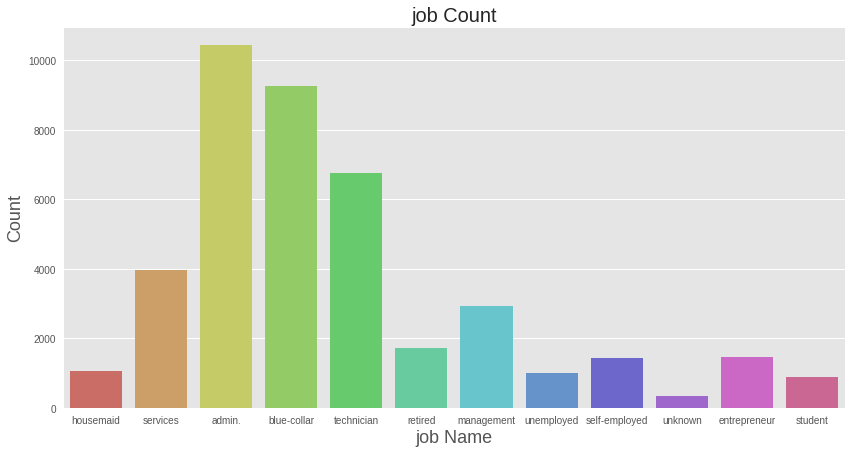

In [0]:
# the top 10 of browsers represent % of total
print("Percentual of job: ")
print((df['job'].value_counts()[:12])) # printing the top 12 percentage of job

# seting the graph size
plt.figure(figsize=(14,7))

# let explore the browser used by users
sns.countplot(df["job"], palette="hls") # It's a module to count the category's
plt.title("job Count", fontsize=20) # seting the title size
plt.xlabel("job Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show() #use plt.show to render the graph that we did above

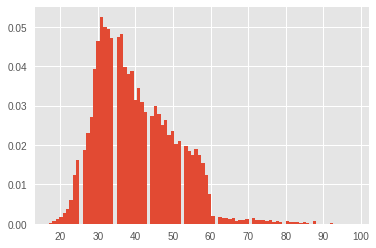

In [0]:
df['age'].hist(bins=90, normed=1)

Text(-0.1,18000,'0.89%')

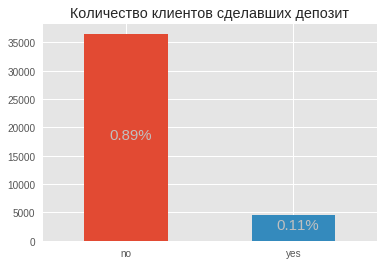

In [0]:
# строим диаграмму
df['y'].value_counts().plot(kind='bar')
# добавяем надпись
plt.title('Количество клиентов сделавших депозит')
plt.xticks([0, 1], ['no', 'yes'], rotation=None)
plt.text(0.9, 2000, '0.11%', fontsize=15, color='silver')
plt.text(-0.1, 18000, '0.89%', fontsize=15, color='silver')

#### Выборка не сбалансированна, одного класса больше чем другого.

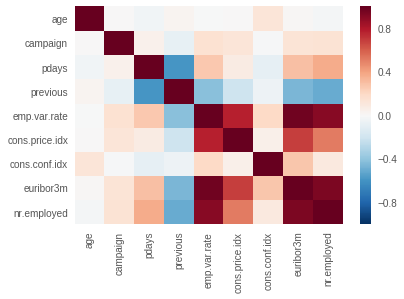

In [0]:
# Анализируемые признаки
predictors = [
 'age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
]

# Ищем коррелирующие признаки
corr = df[predictors].corr()
sns.heatmap(corr)

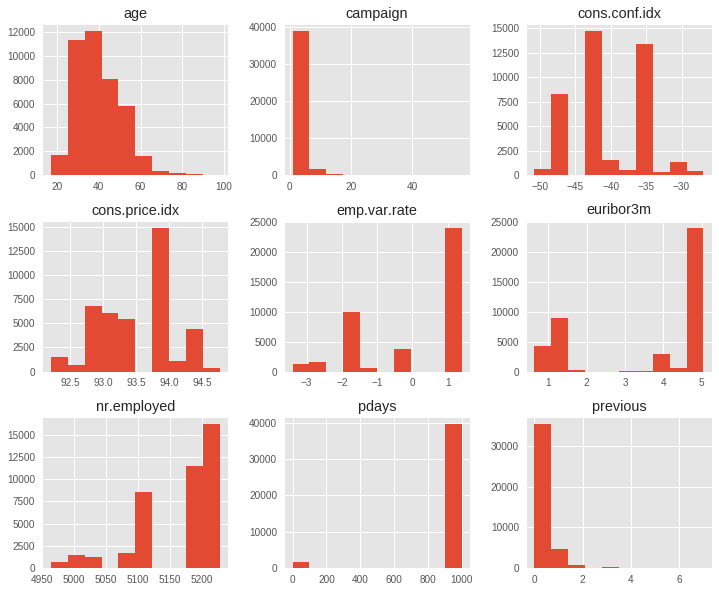

In [0]:
# Строим графики распределения признаков
plots = df[predictors].hist(figsize=(12,10))

#### 1. Посмотрим, как влияет количество сотрудников на целевую переменную

In [0]:
grouped = df.groupby("y")
nr_employed = grouped["nr.employed"].describe()
nr_employed = nr_employed.unstack()
print(nr_employed)

       y  
count  no     36548.000000
       yes     4640.000000
mean   no      5176.166600
       yes     5095.115991
std    no        64.571979
       yes       87.572641
min    no      4963.600000
       yes     4963.600000
25%    no      5099.100000
       yes     5017.500000
50%    no      5195.800000
       yes     5099.100000
75%    no      5228.100000
       yes     5191.000000
max    no      5228.100000
       yes     5228.100000
dtype: float64


#### Можно сделать вывод о том, что бОльшее количество сотрудников негативно влияет на целевую переменную

#### 2. Далее рассмотрим фактор pdays - количество дней, прошедших после последнего контакта с клиентом из предыдущей кампании

In [0]:
grouped = df.groupby("y")
pdays = grouped["pdays"].describe()
pdays = pdays.unstack()
print(pdays)

#### Более "высокие" pdays негативно влияют на выпуск (целевую переменную), логично, чем больше дней прошло после того, как клиент последний раз связывался с предыдущей кампанией, тем меньше шансов того, что клиент сделает банковский депозит.

#### 3. Проанализируем наилучшие месяца для банковских депозитов

y            no       yes
month                    
apr    0.050816  0.013086
aug    0.134092  0.015903
dec    0.002258  0.002161
jul    0.158420  0.015757
jun    0.115543  0.013572
mar    0.006555  0.006701
may    0.312785  0.021511
nov    0.089468  0.010100
oct    0.009784  0.007648
sep    0.007624  0.006215


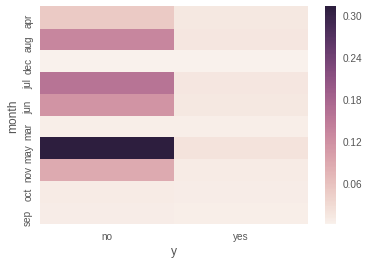

In [0]:
periods = pd.crosstab(df["month"], df["y"]).apply(lambda r: r/len(df))
print(periods)

sns.heatmap(periods)

#### Март, сентябрь, декабрь положительно влияют на объем депозитов 

### Подготовка данных

In [0]:
# выберем предикторы с номинальными признаками 
cols =['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome']
data_1 = df[cols]
data_dummies = pd.get_dummies(data_1)
result_df = pd.concat([data_dummies, df], axis=1)
result_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,0,0,1,0,0,0,0,0,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,0,0,0,0,0,0,0,1,0,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,0,0,0,0,0,0,0,1,0,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,1,0,0,0,0,0,0,0,0,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,0,0,0,0,0,0,0,1,0,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
# удалим предикторы с номинальным признаком
result_df.drop(cols, axis=1, inplace=True)

result_df['y'] = result_df['y'].apply(lambda x: 1 if x =='yes' else 0)

result_df['pdays'] = result_df['pdays'].apply(lambda x: 0 if x == 999 else x) # to remove 999


### <center>Отбор признаков</center>

In [0]:
# Маштабируем переменные и конвертируем назад в Pandas DataFrame
df_scale = preprocessing.scale(result_df)
df_scale = pd.DataFrame(df_scale)
df_scale.columns = result_df.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [0]:
# Выделим обучающую выборку и целевую переменую 
X, y = result_df[[s for s in df_scale.columns if s != 'y']], result_df['y']

In [0]:
first_forest = RandomForestClassifier(n_estimators=1000, max_depth = 5, 
                                      oob_score=True, n_jobs=-1,
                                      random_state=42).fit(X, y)
# Посмотрим точность предсказания
first_forest.oob_score_

0.8993153345634651

In [0]:
# проанализируем важность предикторов
first_forest_predictions = first_forest.predict(X)
features = pd.DataFrame(first_forest.feature_importances_, index=X.columns,
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features

,Importance
nr.employed,0.196055
euribor3m,0.173554
pdays,0.118123
poutcome_success,0.101557
emp.var.rate,0.085790
cons.conf.idx,0.073592
cons.price.idx,0.056220
previous,0.025065
age,0.021906
poutcome_nonexistent,0.021165


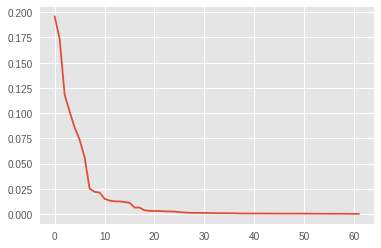

In [0]:
# Кривая оценок важности признаков
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist())

Анализируя оценки важности можно сделать следующие выводы:
1. Такие признаки как: образование клиента, его семейное положение и день недели последнего контакта с клиентом имеют малый вес, поэтому практически не влияют на целевую переменную. Эти признаки не будут использоваться в обучающей выборке.
2. Показатели описывающие клиента с маленькими значениями, например: loan, job, default и другие, все же могут вносить незначительные коррективы, поэтому удаляться не будут.

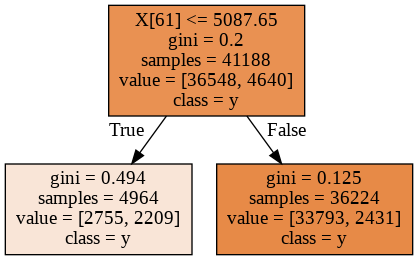

In [0]:
clf = tree.DecisionTreeClassifier(max_depth =1)
clf.fit(X,y)

tree.export_graphviz(clf)

features = ['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'age','campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
target = ['y']

out = StringIO()
dot_data = tree.export_graphviz(clf, class_names=target,filled=True)
 
graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Вывод:**
Дерево делится при количестве работников равным 5087, что говорит о том, что если число сотрудников > 5087, то есть высокая вероятность того, что срочный депозит не будет открыт.

In [0]:
X = result_df[[
    'nr.employed',
    'euribor3m',
    'emp.var.rate',
    'cons.conf.idx',
    'pdays',
    'cons.price.idx',
    'poutcome_success',
    'contact_telephone',
    'contact_cellular',
    'poutcome_nonexistent',
    'previous',
    'month_may',
    'age',
    'default_no',
    'month_oct',
    'default_unknown',
    'month_mar',
    'month_apr',
    'poutcome_failure',
    'campaign',
    'job_blue-collar',
    'month_sep',
]]

### <center>Построение модели классификации</center>

In [0]:
# Разбиваем на тестовую и обучающую выборку 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Попробуем четыре разных классификатора: логистическую регрессию, метод ближайших соседей, Gradient boosting, Random Forest и SVM. В качестве меры будем использовать accuracy.

In [0]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(), 
               RandomForestClassifier(), 
               SVC()]
classifiers_name = ['LogisticRegression',
                    'KNeighborsClassifier',
                    'GradientBoostingClassifier', 
                    'RandomForestClassifier', 
                    'SVC']
# Настройка параметров выбранных алгоритмов с помощью GridSearchCV 
n_folds = 5
scores = []
fits = []
logistic_params = {'penalty': ('l1', 'l2'),
                   'C': (.05,.1,1,5)}
knn_params = {'n_neighbors': list(range(3, 12, 2))}
gbm_params = {'n_estimators': [100, 300, 500],
              'learning_rate':(0.1, 0.5, 1),
              'max_depth': list(range(3, 6)), 
              'min_samples_leaf': list(range(10, 31, 10))}
forest_params = {'n_estimators': [100, 300, 500],
                 'criterion': ('gini', 'entropy'), 
                 'max_depth': list(range(3, 6)), 
                 'min_samples_leaf': list(range(10, 31, 10))}

svm_param = {'kernel' : ('linear', 'rbf'), 'C': (.5, 1, 2)}
params = [logistic_params, knn_params, gbm_params, forest_params, svm_param]

### <center>Кросс-валидация</center>

In [0]:
for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    grid = GridSearchCV(clf, clf_params, 
                        cv=StratifiedKFold(n_splits=n_folds,
                        shuffle=False, random_state=42), 
                        n_jobs=-1, scoring="accuracy")
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_, "\n")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.8997814885753594 
 {'C': 0.1, 'penalty': 'l2'} 

KNeighborsClassifier 0.8929563786452291 
 {'n_neighbors': 11} 

GradientBoostingClassifier 0.9013731150017534 
 {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20, 'n_estimators': 100} 

RandomForestClassifier 0.8999163721708165 
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100} 



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.8967600960371199 
 {'C': 0.5, 'kernel': 'rbf'} 



In [0]:
grid_value = max(scores)
grid_index = [i for i in range(len(scores)) if scores[i]==grid_value][0]
print("Лучший классификатор при GridSearch:",
      classifiers_name[grid_index], grid_value)
print(fits[grid_index])

Лучший классификатор при GridSearch: GradientBoostingClassifier 0.9013731150017534
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 20, 'n_estimators': 100}


### <center>Финальный прогноз для отложенной выборки</center>

In [0]:
final_gbm = GradientBoostingClassifier(n_estimators=300, 
                    min_samples_leaf=10, learning_rate=0.1, max_depth=4)
final_gbm.fit(X_train, y_train)
final_pred = final_gbm.predict(X_test)
accuracy_score(y_test, final_pred), f1_score(y_test, final_pred)

(0.8956057295460063, 0.39436619718309857)

### <center>Оценка модели с описанием выбранной метрики</center>

Построена модель предсказания, подпишет ли клиент срочный депозит. Модель предсказывает с 90%-ной долей правильных ответов на отложенных 10% выборки. Но accuracy не очень хорошо характеризует качество модели из-за сильного дисбаланса в целевой переменной (~90% против ~10%), но, попробовав в качестве целевой F1-score метрику результаты сильно уходшились (0.39), поэтому я решил оставить accuracy.

## <center>Общие выводы</center>

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости. Наблюдаются определенные закономерности - результат предыдущей маркетинговой кампании, количество дней, прошедших после последнего контакта с клиентом из предыдущей кампании, ставка межбанковского кредитования. 
Имеет влияние количество сотрудников кампании - если их количество превышает ~5000, то вероятность того, что клиент сделает депозит крайне мала.
Так же были выявлены наилучшие месяцы для количества клиаентов, сделавших депозит: март, сентябрь, декабрь.

